In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame,Series
from FlowControl import add_to_class,NoKernel, SVC

In [2]:
from cvxopt import matrix,solvers
from sklearn.metrics import confusion_matrix

In [3]:
from matplotlib import cm

<h1>Kernel Methods for SVM</h1>

<h2>1. Features mapping</h2>

In [4]:
def generate_data(seed,points):
    rng = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed + 10)

    x0_ = rng.normal(loc = 0.,scale = 5,size = points)
    x1_ = rng.normal(loc = 0.,scale = 3,size = points)
    X_data_pre = np.vstack((x0_,x1_)).T

    sigma = rng.uniform(size = 4).reshape(2,2)
    avg = (sigma[0,1] + sigma[1,0])/2
    sigma[1,0],sigma[0,1] = avg,avg
    _,U = np.linalg.eig(sigma)

    X_data = (U @ X_data_pre.T).T
    tr_mat = rng2.uniform(size = 4).reshape(2,2)
    z_p = np.sum(X_data * np.sum(tr_mat[np.newaxis,:,:] * X_data[:,np.newaxis,:],axis = 2),axis = 1)
    boundary_rng = rng2.uniform(size = len(z_p))
    y_data = np.where((z_p < 1) * (boundary_rng > 0.1), 0 , 1)
    return X_data,y_data

def plot_points(X_data,y_data,ax,titles = ["y=0","y=1"]):
    classes = np.unique(y_data)
    for i,cl in enumerate(classes):
        points = y_data == cl
        points_tab = [X_data[points,i] for i in range(X_data.shape[1])]
        ax.scatter(*points_tab,color = cm.viridis( i / len(classes)) ,alpha=0.5,label = titles[i])

def confusion_matrix_vis(y_test,y_pred,ax):
    cm_ = confusion_matrix(y_pred,y_test)
    m,n = cm_.shape
    cm_copy = np.zeros((m,n))
    for i in range(m):
        norm = cm_[i,:].sum()
        for j in range(n):
            value = np.round(cm_[i,j] / norm,2)
            ax.text(j,i,value,color = "black",ha = "center",va = "center")
            cm_copy[i,j] = value
    im = ax.imshow(cm_copy,alpha=0.7)
    ax.set_title("confusion matrix")
    ax.set_xticks([0,1],[1,0],color = "black")
    ax.set_yticks([0,1],[1,0],color = "black")
    ax.set_xlabel("predicted label")
    ax.set_ylabel("true label")
    return im


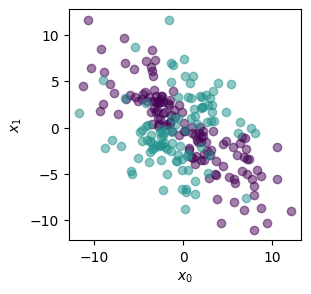

In [5]:
X_data,y_data = generate_data(26,231)
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot()
ax.set_xlabel(r"$x_{0}$")
ax.set_ylabel(r"$x_{1}$")
plot_points(X_data,y_data,ax)
plt.show()

Generated dataset can't be linearly separated. Insted we can separate data linearly in $3$-dimensional space with basis functions of quadratic form.

After the following mapping:
$$
\phi(
    \left[
        \begin{array}{c}
            x_{0} \\
            x_{1}
        \end{array}
    \right]
) = 
\left[
        \begin{array}{c}
            x_{0}^{2} \\
            \sqrt{2}x_{0}x_{1} \\
            x_{1}^{2}
        \end{array}
    \right]
$$
data can be separated by a hyper-plane.

Let's calculate the kernel for this mapping:
$$
K(x,z) = \langle \phi(\vec{x}),\phi(\vec{z}) \rangle = \left[\begin{array}{ccc}
            x_{0}^{2} & \sqrt{2}x_{0}x_{1} & x_{1}^{2}
        \end{array}\right]\left[
        \begin{array}{c}
            z_{0}^{2} \\
            \sqrt{2}z_{0}z_{1} \\
            z_{1}^{2}
        \end{array}
    \right]=x_{0}^{2}z_{0}^{2} + 2x_{0}x_{1}z_{0}z_{1} + x_{1}^{2}z_{1}^{2} = \langle \vec{x},\vec{z} \rangle^{2}
$$

On the basis of the assumption, that after transformation our data is linearly separable, we can apply the SVC algorithm one more time, but now with transformed features:
$$
\max_{\lambda_{i}}\mathcal{L}(\lambda_{i}) = \sum_{i=1}^{n}\lambda_{i} -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)}\langle \phi(\vec{x}^{(i)}),\phi(\vec{x}^{(j)}) \rangle _{d} \hspace{1cm} \text{s.t.} \hspace{1cm} 
\left\{
\begin{array}{l}
0 \leq \lambda_{i} \leq C\\
\sum_{i=1}^{n}\lambda_{i}y^{(i)} = 0
\end{array}
\right.
$$

<h3>1.1 Features mapping implementation</h3>

In [6]:
class quadratic_SVC(SVC):
    def phi(self,X_data):
        return np.vstack((X_data[:,0] ** 2,np.sqrt(2)*X_data[:,0] * X_data[:,1], X_data[:,1] ** 2)).T

In [7]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,random_state=52)

In [8]:
model_quadratic_SVC = quadratic_SVC()
th,b = model_quadratic_SVC.fit(X_train,y_train,C = 0.1)
print("boundary parameters: ",th,b)

boundary parameters:  [0.0637105  0.19623445 0.13948421] -0.41571358553952104


In [9]:
y_pred_m1 = model_quadratic_SVC.predict(X_test)
y_pred = np.where(y_pred_m1==-1,0,1)
print("accuracy: ",1 - abs((y_test-y_pred)).sum() / len(y_pred))

accuracy:  0.8793103448275862


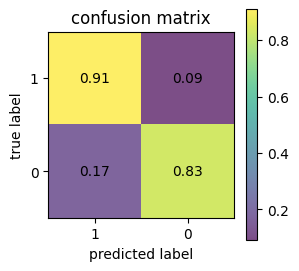

In [10]:
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot()
im = confusion_matrix_vis(y_test,y_pred,ax)
fig.colorbar(im,ax = ax)
plt.show()

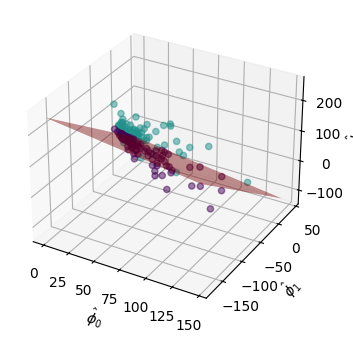

In [11]:
Phi_data = model_quadratic_SVC.phi(X_data)

x0_tt = np.arange(Phi_data[:,0].min(),Phi_data[:,0].max(),1)
x1_tt = np.arange(Phi_data[:,1].min(),Phi_data[:,1].max(),1)
x0_t,x1_t = np.meshgrid(x0_tt,x1_tt)
z = -(th[0]*x0_t + th[1]*x1_t +b)/ th[2]


fig = plt.figure(figsize = (5,4))
ax = fig.add_subplot(projection = "3d")
ax.plot_surface(x0_t,x1_t,z,alpha = 0.5,color = "red")
ax.set_xlabel(r"$\hat{\phi}_{0}$")
ax.set_ylabel(r"$\hat{\phi}_{1}$")
ax.set_zlabel(r"$\hat{\phi}_{2}$")
plot_points(Phi_data,y_data,ax)
plt.show()

In [12]:
x0_ = np.arange(-15,15,0.05)
x1_ = np.arange(-12,12,0.05)

x0,x1 = np.meshgrid(x0_,x1_)
X_test_tot = np.stack((x0,x1),axis = 2).reshape(-1,2)
y_pred_tot = np.where(model_quadratic_SVC.predict(X_test_tot).reshape(len(x1_),len(x0_)) == -1,0,1)


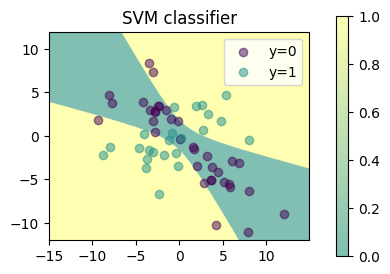

In [13]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot()

plot_points(X_test,y_test,ax)
im = ax.imshow(y_pred_tot,extent=[x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",cmap = "summer",alpha = 0.5,label = "predicted value")
ax.set_title("SVM classifier")
ax.legend()
fig.colorbar(im, ax = ax, fraction=0.04, pad=0.09)
plt.tight_layout()
plt.show()

<h2>2. Kernel trick</h2>

Let's suppose that our feature space is $d$-dimensional. Let's consider a map:
$$
\phi : \mathbb{R}^{d}\rightarrow \mathbb{R}^{r}
$$
By applying the above transformation, we can incorporate feature engeneering to higher dimensional space. For example we can transform linear data points into polynomial basis.

Let's consider the following expression:
$$
\langle \phi(\vec{x}^{(i)}),\phi(\vec{x}^{(j)}) \rangle = K_{ij}
$$
We can cosntruct the $n\times n$ matrix out of these elements:
$$
K = \left[
\begin{array}{cccc}
\langle \phi(\vec{x}^{(1)}),\phi(\vec{x}^{(1)}) \rangle & \langle \phi(\vec{x}^{(1)}),\phi(\vec{x}^{(2)}) \rangle & \ldots & \langle \phi(\vec{x}^{(1)}),\phi(\vec{x}^{(n)}) \rangle \\
\langle \phi(\vec{x}^{(2)}),\phi(\vec{x}^{(1)}) \rangle & \langle \phi(\vec{x}^{(2)}),\phi(\vec{x}^{(2)}) \rangle & \ldots & \langle \phi(\vec{x}^{(2)}),\phi(\vec{x}^{(n)}) \rangle \\
\ldots & \ldots & \ldots & \ldots \\
\langle \phi(\vec{x}^{(n)}),\phi(\vec{x}^{(1)}) \rangle & \langle \phi(\vec{x}^{(n)}),\phi(\vec{x}^{(2)}) \rangle & \ldots & \langle \phi(\vec{x}^{(n)}),\phi(\vec{x}^{(n)}) \rangle \\
\end{array}
\right]
$$

Matrix $K$ is symmetric, positive,semi-definite:
$$
\vec{x}^{T}K\vec{x} = \sum_{i = 1}^{n}\sum_{j= 1}^{n}x_{i}x_{j}\sum_{k=1}^{r}\phi_{k}(\vec{x}^{(i)})\phi_{k}(\vec{x}^{(j)}) = \sum_{k=1}^{r}\Big(\sum_{i=1}^{n}x_{i}\phi_{k}(\vec{x}^{(i)}) \Big)^{2} \geq 0
$$

On the other hand, if $n\times n$ matrix is symmetric and positive,semi-definite, then we can carry out spectral decomposition for this matrix with non-negative eigenvalues $\lambda_{i}$ and corresponding orthonormal eigenvectors: $v_{i}$. So that the element $\hat{K}_{ij}$ of diagonal matrix can be written as $\hat{K}_{ij} = \langle \sqrt{\lambda_{i}}v_{i},\sqrt{\lambda_{j}}v_{j} \rangle = \delta_{ij}\sqrt{\lambda_{i}}\sqrt{\lambda_{j}}$. On the contrary transformation from the computational basis $e_{i}$ to the diagonal one is given by orthogonal matrix $O$. So that, if:
$$v_{i} = \sum_{j=1}^{n}o_{ij}e_{i}$$
then:
$$\hat{K} = O^{T}KO $$
$$K_{ij} = (O\hat{K}O^{T})_{ij} = \sum_{k=1}^{n}\sum_{l=1}^{n}o_{ik}\hat{K}_{kl}o_{jl} = \sum_{k=1}^{n}\sum_{l=1}^{n}o_{ik}\langle \bar{v}_{k},\bar{v}_{l} \rangle o_{jl}$$
where $\bar{v}_{k} = \sqrt{\lambda_{k}}v_{k}$. Therefore:
$$K_{ij} =  \langle \sum_{k=1}^{n}o_{ik}\bar{v}_{k},\sum_{l=1}^{n}o_{jl}\bar{v}_{l} \rangle $$
$K_{ij}$ can be constructed by taking a scalar product of vectors $\phi_{i},\phi_{j}$ where $\phi_{k} = \sum_{j = 1}^{n}o_{kj}\sqrt{\lambda_{j}}v_{j}$. Of course we can also find a function that maps from feature space to $n$ dimensional space as following: 
$$\phi(\vec{x}^{(k)}) = \phi_{k} = \sum_{j = 1}^{n}o_{kj}\sqrt{\lambda_{j}}v_{j}$$ 

To sum up:
- If we are given a $n\times n$, symmetric, positive, semi-definite matrix $K$, we can be absoultely sure, that there exist a function $\phi$ which maps from feature space to higher dimensional space and elements of matrix $K$ can be written as: $K_{ij} = \langle \phi(\vec{x}^{(i)}),\phi(\vec{x}^{(j)}) \rangle$. In other words: if we are given generating function $K(z,y)$ for which matrix $K_{ij} = K(\vec{x}^{(i)},\vec{x}^{(j)})$ fullfills the aformentioned conditions, then we are sure that there exists mapping $phi$, suvh that $K_{ij} = \langle \phi(\vec{x}^{(i)}),\phi(\vec{x}^{(j)}) \rangle$.

Function $K$ is called the **Kernel**. It is particularly usefull because we don't have to calculate explicitly the mapping $\phi$.

<h3>2.1 Kernels for SVM</h3>

Assuming that we've chosen specific kernel which correspond to mapping to higher dimensional space, we can find the optimal decision boundary without any need to calculate explicitly the values of function $\phi$.
$$
\max_{\lambda_{i}}\mathcal{L}(\lambda_{i}) = \sum_{i=1}^{n}\lambda_{i} -\frac{1}{2}\sum_{i=1}^{n}\sum_{j=1}^{n}\lambda_{i}\lambda_{j}y^{(i)}y^{(j)} K(\vec{x}^{(i)},\vec{x}^{(j)}) \hspace{1cm} \text{s.t.} \hspace{1cm} 
\left\{
\begin{array}{l}
0 \leq \lambda_{i} \leq C\\
\sum_{i=1}^{n}\lambda_{i}y^{(i)} = 0
\end{array}
\right.
$$
that is the famous **Kernel Trick**.

Assuming that we've found optimal parameters $\lambda_{i}$ we can compute the expected output:
$$
\vec{\theta} = \sum_{i=1}^{n}\lambda_{i}y^{(i)}\phi(\vec{x}^{(i)})
$$
$$
\vec{\theta}\phi(\vec{x}) + b = \sum_{i=1}^{n}\lambda_{i}y^{(i)}\langle \phi(\vec{x}^{(i)}), \phi(\vec{x})  \rangle + b = 
\sum_{i\in SV}\lambda_{i}y^{(i)}K(\vec{x}^{(i)},\vec{x}) + b
$$
where:
$$
b = \frac{1}{n_{SV}}\sum_{i\in{SV}}\Big(y^{(i)} - \sum_{j\in SV} \lambda_{j}y^{(j)}K(\vec{x}^{(j)},\vec{x}^{(i)}) \Big)
$$

Kernels should be chosen such that they correspond to basis functions:
- **linear kernel** $K(\vec{x},\vec{z}) = \langle \vec{x},\vec{z} \rangle$
- **polynomial kernel** $K(\vec{x},\vec{z}) = (\gamma\langle \vec{x},\vec{z} \rangle +r)^{d}$
- **radial basis functions kernerl** $K(\vec{x},\vec{z}) = \exp(-\gamma||\vec{x}-\vec{z}||^{2})$
- **sigmoid kernel** $K(\vec{x},\vec{z}) = \tanh(\gamma\langle \vec{x},\vec{z} \rangle +r)$

In [14]:
class KernelizedSVC:
    def __init__(self):
        pass

    def fit(self,X_data,y_data):
        raise NotImplementedError
    
    def predict(self,X_data):
        raise NotImplementedError
    
    def Kernel(self,X_data,X_data_right,kernel,**kwargs):
        raise NotImplementedError

In [15]:
@add_to_class(KernelizedSVC)
def fit(self, X_data, y_data,**kwargs):
    if len(X_data.shape) == 2:
        n, d = X_data.shape
    else:
        n = X_data.shape[0]
        d = 1
    
    classes = np.unique(y_data)
    y_data = np.where(y_data == classes[0], -1, 1)

    ker_name = kwargs.get("kernel","linear")
    gamma = kwargs.get("gamma",0.1)
    r_ = kwargs.get("r",0.1)
    d = kwargs.get("deg",2)
    self.Kernel_method = lambda X_data,X_data_right: self.Kernel(X_data,X_data_right,ker_name,gamma = gamma,r = r_,deg = d)

    K = self.Kernel_method(X_data,X_data)

    P = matrix(np.outer(y_data, y_data) * K) 
    q = matrix(-np.ones(n))                               
    A = matrix(y_data.astype('double'), (1, n)) 
    b = matrix(0.0)                       
    if "C" in kwargs.keys():
        C = kwargs.get("C")
        G = matrix(np.vstack((-np.eye(n),np.eye(n))))                   
        h = matrix(np.hstack((np.zeros(n),np.ones(n)*C))) 
    else:
        G = matrix(-np.eye(n))                   
        h = matrix(np.zeros(n)) 
    
    self.lam = np.ravel(solvers.qp(P, q, G, h, A, b)["x"])
    self.eps = self.lam > 1e-5 # support vectors
    self.b_ = np.mean(y_data - np.sum(y_data[np.newaxis,:]* self.lam[np.newaxis,:] * K,axis = 1)) 
    self.X_train = X_data
    self.y_train = y_data

@add_to_class(KernelizedSVC)
def predict(self, X_data):
    mess = "No model fitted yet"
    assert hasattr(self,"eps") and hasattr(self,"Kernel_method") and hasattr(self,"X_train") and hasattr(self,"b_") and hasattr(self,"lam"), mess
    K = self.Kernel_method(X_data,self.X_train)
    return np.sign(np.sum(self.y_train[np.newaxis,:]* self.lam[np.newaxis,:] * K[:,:] ,axis = 1) + self.b_)

@add_to_class(KernelizedSVC)
def Kernel(self,X_data,X_data_right,kernel,**kwargs):
    gamma = kwargs.get("gamma",0.1)
    r_ = kwargs.get("r",0.1)
    d = kwargs.get("deg",2)

    if kernel == "linear":
        return X_data @ X_data_right.T
    elif kernel == "poly":
        return (gamma * X_data @ X_data_right.T + r_)**d
    elif kernel == "rbf":
        return np.exp(-gamma * np.sum((X_data[:,:,np.newaxis] - X_data_right.T[np.newaxis,:,:])**2,axis = 1))
    elif kernel == "sigmoid":
        return np.tanh(gamma * X_data @ X_data_right.T + r_)
    else: 
        raise NoKernel

In [16]:
model_kernel_SVC = KernelizedSVC()
model_kernel_SVC.fit(X_train,y_train,C = 0.001,kernel = "poly",deg=2,r = 0,gamma = 1)

In [17]:
y_pred_ker_m1= model_kernel_SVC.predict(X_test)
y_pred_ker = np.where(y_pred_ker_m1==-1,0,1)
print("accuracy: ",1 - abs((y_test-y_pred_ker)).sum() / len(y_pred_ker))

accuracy:  0.896551724137931


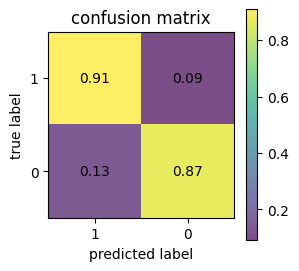

In [18]:
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot()
im = confusion_matrix_vis(y_test,y_pred_ker,ax)
fig.colorbar(im,ax = ax)
plt.show()

In [19]:
x0_ = np.arange(-15,15,0.05)
x1_ = np.arange(-12,12,0.05)

x0,x1 = np.meshgrid(x0_,x1_)
X_test_tot = np.stack((x0,x1),axis = 2).reshape(-1,2)
y_pred_tot_kernel = np.where(model_kernel_SVC.predict(X_test_tot).reshape(len(x1_),len(x0_)) == -1,0,1)


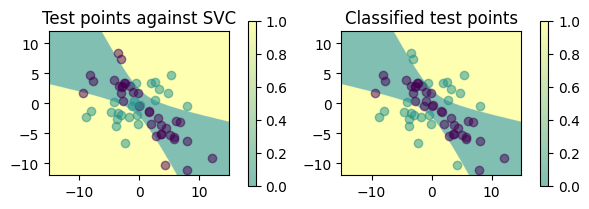

In [20]:
fig = plt.figure(figsize = (6,10))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_points(X_test,y_test,ax)
plot_points(X_test,y_pred_ker,ax2)
im = ax.imshow(y_pred_tot_kernel,extent=[x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",cmap = "summer",alpha = 0.5,label = "predicted value")
im2 = ax2.imshow(y_pred_tot_kernel,extent=[x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",cmap = "summer",alpha = 0.5,label = "predicted value")
ax.set_title("Test points against SVC")
ax2.set_title("Classified test points")
fig.colorbar(im, ax = ax, fraction=0.04, pad=0.09)
fig.colorbar(im2, ax = ax2, fraction=0.04, pad=0.09)
plt.tight_layout()
plt.show()

<h3>Comparison with scikit-learn implementation</h3>

In [21]:
from sklearn.svm import SVC

clf = SVC(kernel = 'poly',degree=2)
clf.fit(X_train,y_train)

y_pred_sk = clf.predict(X_test)


In [22]:
x0_ = np.arange(-15,15,0.05)
x1_ = np.arange(-12,12,0.05)

x0,x1 = np.meshgrid(x0_,x1_)
X_test_tot = np.stack((x0,x1),axis = 2).reshape(-1,2)
y_pred_tot_sk = clf.predict(X_test_tot).reshape(len(x1_),len(x0_)) 

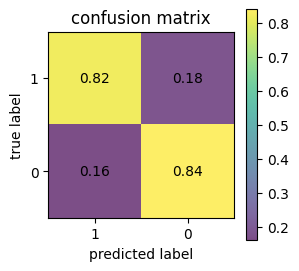

In [23]:
fig = plt.figure(figsize = (3,3))
ax = fig.add_subplot()
im = confusion_matrix_vis(y_test,y_pred_sk,ax)
fig.colorbar(im,ax = ax)
plt.show()

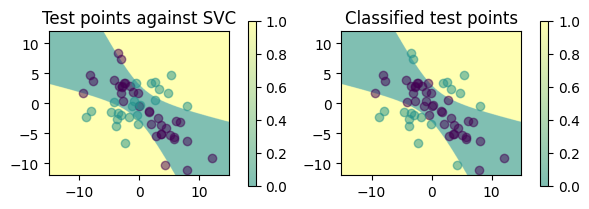

In [24]:
fig = plt.figure(figsize = (6,10))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

plot_points(X_test,y_test,ax)
plot_points(X_test,y_pred_sk,ax2)
im = ax.imshow(y_pred_tot_sk,extent=[x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",cmap = "summer",alpha = 0.5,label = "predicted value")
im2 = ax2.imshow(y_pred_tot_sk,extent=[x0_.min(),x0_.max(),x1_.min(),x1_.max()],origin = "lower",cmap = "summer",alpha = 0.5,label = "predicted value")
ax.set_title("Test points against SVC")
ax2.set_title("Classified test points")
fig.colorbar(im, ax = ax, fraction=0.04, pad=0.09)
fig.colorbar(im2, ax = ax2, fraction=0.04, pad=0.09)
plt.tight_layout()
plt.show()